In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils

import tensorflow as tf
import numpy as np
import time
from keras.utils import np_utils

%matplotlib inline

Using TensorFlow backend.


In [2]:
flags = tf.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 8, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'euclidean', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 4, 'Number of coarsened graphs.')

# Directories.
flags.DEFINE_string('dir_data', os.path.join('..', 'data', 'mnist'), 'Directory to store data.')

# Image Size (for rescaling, forming grid graph, etc)

In [3]:
#Square grid, so length == breadth always
m = 28
length = m
breadth = m

# Number of labels to be predicted per image

In [35]:
num_labels_per_image = 1

# Number of channels per image (RGB = 3)

In [5]:
num_channels = 3

# Feature graph

Layer 0: M_0 = |V| = 1024 nodes (240 added),|E| = 3198 edges
Layer 1: M_1 = |V| = 512 nodes (99 added),|E| = 1452 edges
Layer 2: M_2 = |V| = 256 nodes (36 added),|E| = 682 edges
Layer 3: M_3 = |V| = 128 nodes (9 added),|E| = 333 edges
Layer 4: M_4 = |V| = 64 nodes (0 added),|E| = 165 edges
Execution time: 0.24s


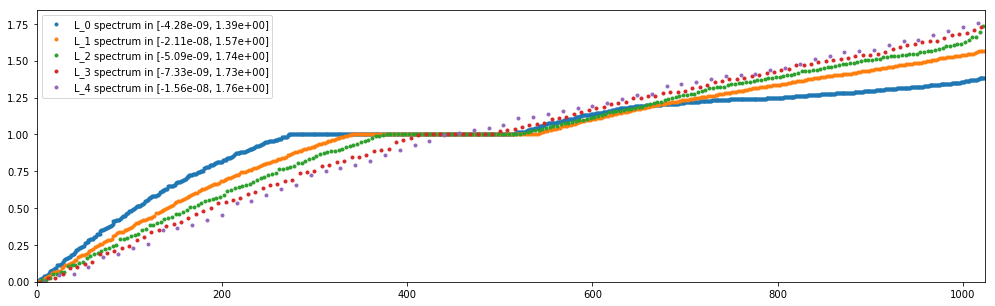

In [10]:
def grid_graph(m, corners=False):
    z = graph.grid(m)
    dist, idx = graph.distance_sklearn_metrics(z, k=FLAGS.number_edges, metric=FLAGS.metric)
    A = graph.adjacency(dist, idx)
    # Connections are only vertical or horizontal on the grid.
    # Corner vertices are connected to 2 neightbors only.
    if corners:
        import scipy.sparse
        A = A.toarray()
        A[A < A.max()/1.5] = 0
        A = scipy.sparse.csr_matrix(A)
        print('{} edges'.format(A.nnz))
    
    return A

t_start = time.process_time()
A = grid_graph(m, corners=False)
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
graph.plot_spectrum(L)
del A

# Image Data

In [11]:
train_img_dir = '/home/anjali/Documents/CVIT/Dataset/PASCAL_VOC/VOCtrainval/VOC2007/JPEGImages/'
test_img_dir = '/home/anjali/Documents/CVIT/Dataset/PASCAL_VOC/VOCtest/VOC2007/JPEGImages/'

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image
import glob, time, numpy as np, scipy

num_train_imgs = len(glob.glob(train_img_dir+'*'))
num_test_imgs = len(glob.glob(test_img_dir+'*'))

new_shape = (length,breadth, 3)

train_data = np.zeros(shape=(num_train_imgs,length*breadth, num_channels), dtype=np.float32)
test_data = np.zeros(shape=(num_test_imgs,length*breadth, num_channels), dtype=np.float32)

train_imgs = sorted(glob.glob(train_img_dir+'*'))
test_imgs = sorted(glob.glob(test_img_dir+'*'))

i=0
while i<min(num_train_imgs, num_test_imgs):
    x = load_img(train_imgs[i])
    img = scipy.misc.imresize(img_to_array(x), new_shape).astype(np.float32)
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    
    train_data[i,:,0] = r.flatten()
    train_data[i,:,1] = g.flatten()
    train_data[i,:,2] = b.flatten()
    
    y = load_img(test_imgs[i])
    img = scipy.misc.imresize(img_to_array(y), new_shape).astype(np.float32)
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    
    test_data[i,:,0] = r.flatten()
    test_data[i,:,1] = g.flatten()
    test_data[i,:,2] = b.flatten()
    
    i+=1

while i<num_train_imgs:
    x = load_img(train_imgs[i])
    img = scipy.misc.imresize(img_to_array(x), new_shape).astype(np.float32)
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    
    train_data[i,:,0] = r.flatten()
    train_data[i,:,1] = g.flatten()
    train_data[i,:,2] = b.flatten()
    
    i+=1


while i<num_test_imgs:
    y = load_img(test_imgs[i])
    img = scipy.misc.imresize(img_to_array(y), new_shape).astype(np.float32)
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    
    test_data[i,:,0] = r.flatten()
    test_data[i,:,1] = g.flatten()
    test_data[i,:,2] = b.flatten()
    
    i+=1

del x, y, img, r, g, b, new_shape


# Labels

In [12]:
import scipy.io
label_dir = "/home/anjali/Documents/CVIT/Dataset/PASCAL_VOC/Labels/"

mat_contents = scipy.io.loadmat(label_dir+"train_labels.mat")
train_labels = np.array(mat_contents['train_labels'])

mat_contents = scipy.io.loadmat(label_dir+"test_labels.mat")
test_labels = np.array(mat_contents['test_labels'])

# Split test into validation set and test set

In [13]:
num_val = 500

val_data = test_data[0:num_val]
val_labels = test_labels[0:num_val]

test_data = test_data[num_val:]
test_labels = test_labels[num_val:]


In [15]:
#Coarsening the formed images

train_data = coarsening.perm_data(train_data, perm)
val_data = coarsening.perm_data(val_data, perm)
test_data = coarsening.perm_data(test_data, perm)

print(val_data.shape)
print(test_data.shape)

(500, 1024, 3)
(4452, 1024, 3)


# Neural networks

In [56]:
common = {}
common['dir_name']       = 'VOC/'
common['num_epochs']     = 20
common['batch_size']     = 1000
common['decay_steps']    = train_data.shape[0] / common['batch_size']
common['eval_frequency'] = 30 * common['num_epochs']
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = test_labels.shape[1]  # number of classes

model_perf = utils.model_perf()


In [57]:
if True:
    name = 'softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.01
    params['decay_rate']     = 0.9
    params['momentum']       = 0.9
    params['F']              = []
    params['F_0']            = num_channels
    params['K']              = []
    params['p']              = []
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, num_labels_per_image, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1024
  layer 1: logits (softmax)
    representation: M_1 = 20
    weights: M_0 * M_1 = 1024 * 20 = 20480
    biases: M_1 = 20
step 100 / 100 (epoch 19.96 / 20):
  learning_rate = 1.14e-05, loss_average = 1.46e+05
  validation precision: 0.06, recall : 0.05, f_measure: 0.06, mAP 0.13, MAP 0.19
  time: 8s (wall 6s)
validation peaks: precision = 0.06, recall = 0.05, f_measure = 0.05588615212823098, mAP = [ 0.1285448], MAP = [ 0.19330222]
train precision: 0.16, recall : 0.10, f_measure: 0.12, mAP 0.26, MAP 0.27
time: 1s (wall 1s)
test  precision: 0.06, recall : 0.05, f_measure: 0.06, mAP 0.14, MAP 0.20
time: 1s (wall 1s)


In [59]:
# Common hyper-parameters for networks with one convolutional layer.
common['regularization'] = 0
common['dropout']        = 1
common['learning_rate']  = 0.02
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [10]
common['F_0']            = num_channels
common['K']              = [20]
common['p']              = [1]
common['M']              = [C]

In [39]:
if True:
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'fourier'
    params['K'] = [L[0].shape[0]]
    model_perf.test(models.cgcnn(L, num_labels_per_image, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1024
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1024 * 10 / 1 = 10240
    weights: F_0 * F_1 * K_1 = 3 * 10 * 1024 = 30720
    biases: F_1 = 10
  layer 2: logits (softmax)
    representation: M_2 = 20
    weights: M_1 * M_2 = 10240 * 20 = 204800
    biases: M_2 = 20
step 6000 / 200440 (epoch 5.99 / 200):
  learning_rate = 1.55e-02, loss_average = 4.85e+00
  validation precision: 0.02, recall : 0.05, f_measure: 0.03, mAP 0.05, MAP 0.30
  time: 429s (wall 135s)


KeyboardInterrupt: 

In [60]:
if True:
    name = 'sgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'spline'
    model_perf.test(models.cgcnn(L, num_labels_per_image, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1024
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1024 * 10 / 1 = 10240
    weights: F_0 * F_1 * K_1 = 3 * 10 * 20 = 600
    biases: F_1 = 10
  layer 2: logits (softmax)
    representation: M_2 = 20
    weights: M_1 * M_2 = 10240 * 20 = 204800
    biases: M_2 = 20


KeyboardInterrupt: 

In [ ]:
# With 'chebyshev2' and 'b2relu', it corresponds to cgcnn2_2(L[0], F=10, K=20).
if True:
    name = 'cgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'chebyshev5'
#    params['filter'] = 'chebyshev2'
#    params['brelu'] = 'b2relu'
    model_perf.test(models.cgcnn(L, num_labels_per_image, **params, num_labels_per_image), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
# Common hyper-parameters for LeNet5-like networks.
common['regularization'] = 5e-4
common['dropout']        = 0.5
common['learning_rate']  = 0.02  # 0.03 in the paper but sgconv_sgconv_fc_softmax has difficulty to converge
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [32, 64]
common['F_0']            = num_channels
common['K']              = [25, 25]
common['p']              = [4, 4]
common['M']              = [512, C]

In [ ]:
# Architecture of TF MNIST conv model (LeNet-5-like).
# Changes: regularization, dropout, decaying learning rate, momentum optimizer, stopping condition, size of biases.
# Differences: training data randomization, init conv1 biases at 0.
if True:
    name = 'fgconv_fgconv_fc_softmax' #  'Non-Param'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'fourier'
    params['K'] = [L[0].shape[0], L[2].shape[0]]
    model_perf.test(models.cgcnn(L, num_labels_per_image, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'sgconv_sgconv_fc_softmax'  # 'Spline'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'spline'
    model_perf.test(models.cgcnn(L, num_labels_per_image, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'cgconv_cgconv_fc_softmax'  # 'Chebyshev'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'chebyshev5'
    model_perf.test(models.cgcnn(L, num_labels_per_image, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
model_perf.show()

In [ ]:
if False:
    grid_params = {}
    data = (train_data, train_labels, val_data, val_labels, test_data, test_labels)
    utils.grid_search(params, grid_params, *data, model=lambda x: models.cgcnn(L,**x))